In [33]:
from sklearn.model_selection import train_test_split
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import random
from keras import models, layers
import math
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import tensorflow.keras.backend as K
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
import tensorflow as tf


MAX_TRAIN_STEPS = 10
MAX_VAL_STEPS = 10
MAX_EPOCHS = 100

LIMIT = int(1e2)

BASE_DIR = 'airbus-ship-detection/'

TRAIN_PATH = BASE_DIR + 'train_v2/'
TEST_PATH = BASE_DIR + 'test_v2/'
MASKS_PATH = BASE_DIR + 'train_ship_segmentations_v2.csv'


In [34]:
train = os.listdir(TRAIN_PATH)
test = os.listdir(TEST_PATH)

print(f'Sz of train dataset : {len(train)} |{train[:LIMIT]}')
print(f'Sz of test dataset : {len(test)} |{test[:LIMIT]}')

Sz of train dataset : 192556 |['4a5b2532e.jpg', '34b973fb0.jpg', '133b13bda.jpg', '5ecf4344b.jpg', '96f178a96.jpg', 'b5b6373bb.jpg', 'a78a82b25.jpg', 'c50310bc5.jpg', '531054a2b.jpg', '4235d2d8f.jpg', 'b0f4d07ed.jpg', '0deadf346.jpg', '2a9e2ac00.jpg', 'fa5c0c8b7.jpg', '6098e0ec7.jpg', '46d5ace64.jpg', '4790fd62c.jpg', 'cb9e718ee.jpg', '7ae2572ee.jpg', '6076a2546.jpg', 'c5ab26d22.jpg', '271956629.jpg', '5d8c071c4.jpg', '567261abb.jpg', 'a5ca05522.jpg', '448a95362.jpg', 'bad7a9587.jpg', 'a0c72d497.jpg', '75f2305a4.jpg', 'f56fa13de.jpg', '3cdc5adb9.jpg', '944c752de.jpg', '0af151ad2.jpg', '66a93d57b.jpg', '64c3335d0.jpg', '98f33d745.jpg', '3cf656feb.jpg', '938c8d3d3.jpg', '7ef0386e6.jpg', '7e86c4e26.jpg', '2880e817b.jpg', '84eed2fa0.jpg', 'ffd6a9ac7.jpg', '10dfa91c8.jpg', 'ca18c4ece.jpg', 'bc5a522cb.jpg', '6e7ebfd3f.jpg', '83aadba9d.jpg', '804f0977d.jpg', '65ffb677f.jpg', '877c2026b.jpg', '673e1b210.jpg', 'dcbd287ff.jpg', '9de779fbe.jpg', 'c9b34541b.jpg', 'b17ae157f.jpg', '1d7ff6175.jpg', 

In [35]:
masks = pd.read_csv(MASKS_PATH)
masks

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
...,...,...
231718,fffedbb6b.jpg,NaN
231719,ffff2aa57.jpg,NaN
231720,ffff6e525.jpg,NaN
231721,ffffc50b4.jpg,NaN


In [36]:
print(f'Total amount of unique photos: {len(masks.ImageId.unique())}')

Total amount of unique photos: 192556


In [37]:


def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)
 
def rle_decode(mask_rle, shape = (768,768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T


In [38]:
def concat_mask(mask_list):
    all_masks = np.zeros((768, 768), dtype = np.int16)
    for mask in mask_list:
        if isinstance(mask, str):
            all_masks += rle_decode(mask)
    return np.expand_dims(all_masks, -1)

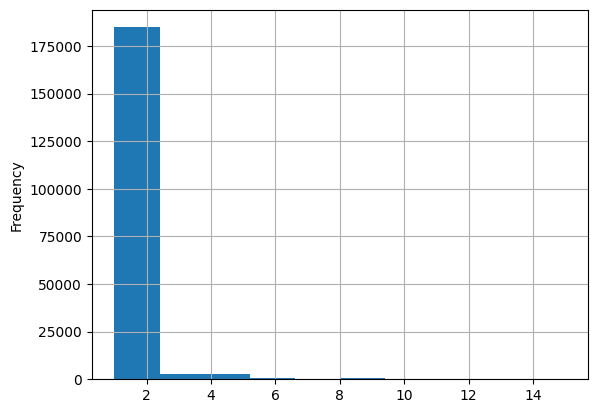

In [39]:
masks.ImageId.value_counts().plot.hist().grid(True)

In [40]:
ships = masks.copy()
ships['Ships'] = ships['EncodedPixels'].notnull().astype(int)
ships = ships.groupby('ImageId').sum().reset_index()

ships.EncodedPixels = ships.EncodedPixels.apply(lambda x: x if x != 0 else '')
ships


,ImageId,EncodedPixels,Ships
0,00003e153.jpg,,0
1,0001124c7.jpg,,0
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...,1
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...,5
4,0001b1832.jpg,,0
...,...,...,...
192551,fffedbb6b.jpg,,0
192552,ffff2aa57.jpg,,0
192553,ffff6e525.jpg,,0
192554,ffffc50b4.jpg,,0


In [41]:
masks.fillna('', inplace = True)
masks

,ImageId,EncodedPixels
0,00003e153.jpg,
1,0001124c7.jpg,
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
...,...,...
231718,fffedbb6b.jpg,
231719,ffff2aa57.jpg,
231720,ffff6e525.jpg,
231721,ffffc50b4.jpg,


In [42]:
train_ships, valid_ships = train_test_split(ships, test_size = 0.25, stratify = ships.Ships)
train_ships

,ImageId,EncodedPixels,Ships
25333,21c5ca36f.jpg,,0
122931,a37fc0d54.jpg,,0
68753,5b82b35df.jpg,,0
48676,40e292f92.jpg,,0
80760,6b41eb0bf.jpg,,0
...,...,...,...
699,00ef28664.jpg,375677 1 376444 3 377211 6 377978 8 378747 8 3...,1
165475,dc30c2c13.jpg,,0
42598,38cd97d7e.jpg,297931 1 298697 4 299463 6 300230 8 300996 10 ...,1
107033,8e49262f9.jpg,392814 4 393582 11 394350 18 395118 22 395885 ...,2


In [43]:
def undersample(df: pd.DataFrame) -> pd.DataFrame:
    return pd.concat([df[df.Ships == 0].sample(n = 25000, random_state = 42), df[df.Ships != 0]])

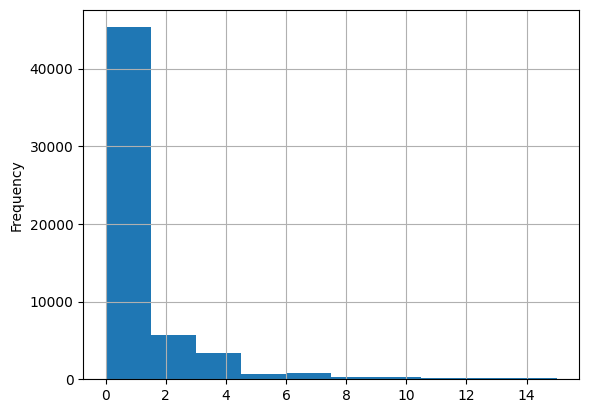

In [44]:
train_ships, valid_ships = undersample(train_ships), undersample(valid_ships)
train_ships.Ships.plot.hist().grid(True)

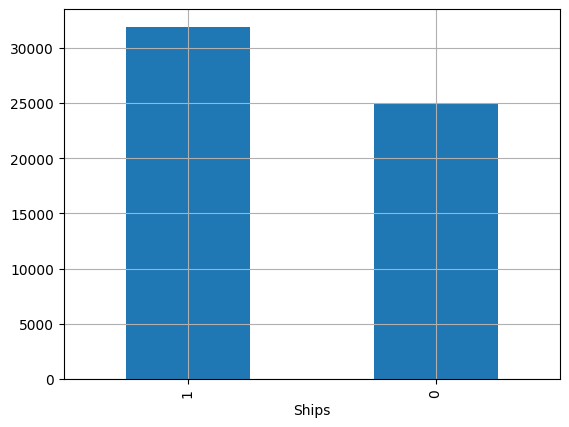

In [45]:


(train_ships.Ships > 0).astype(int).value_counts().plot.bar().grid(True)

In [46]:
train_ships.shape, valid_ships.shape

((56917, 3), (35639, 3))

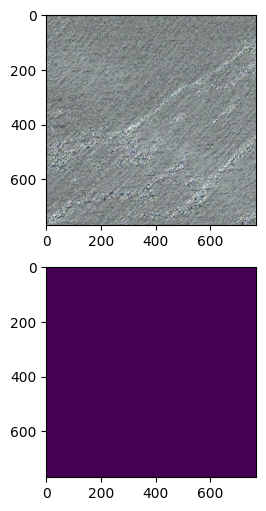

In [47]:


random_img = random.choice(os.listdir(TRAIN_PATH))

test_masks = masks[masks.ImageId == random_img]
msk = concat_mask(list(test_masks.EncodedPixels))

img = cv.imread(TRAIN_PATH + random_img)
fig, axes = plt.subplots(2, 1, figsize=(12, 6))
axes[0].imshow(img)
axes[1].imshow(msk)

In [48]:


def UnetCNN(input_size = (256, 256, 3)):
    inputs = layers.Input(input_size)

    C1 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    C1 = layers.Dropout(0.1)(C1)
    C1 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(C1)
    P1 = layers.MaxPooling2D((2, 2))(C1)

    C2 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(P1)
    C2 = layers.Dropout(0.1)(C2)
    C2 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(C2)
    P2 = layers.MaxPooling2D((2, 2))(C2)

    C3 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(P2)
    C3 = layers.Dropout(0.2)(C3)
    C3 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(C3)
    P3 = layers.MaxPooling2D((2, 2))(C3)

    C4 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(P3)
    C4 = layers.Dropout(0.2)(C4)
    C4 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(C4)
    P4 = layers.MaxPooling2D(pool_size=(2, 2))(C4)

    C5 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(P4)
    C5 = layers.Dropout(0.3)(C5)
    C5 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(C5)

    U6 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(C5)
    U6 = layers.concatenate([U6, C4])
    C6 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(U6)
    C6 = layers.Dropout(0.2)(C6)
    C6 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(C6)

    U7 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(C6)
    U7 = layers.concatenate([U7, C3])
    C7 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(U7)
    C7 = layers.Dropout(0.2)(C7)
    C7 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(C7)

    U8 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(C7)
    U8 = layers.concatenate([U8, C2])
    C8 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(U8)
    C8 = layers.Dropout(0.1)(C8)
    C8 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(C8)

    U9 = layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(C8)
    U9 = layers.concatenate([U9, C1], axis=3)
    C9 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(U9)
    C9 = layers.Dropout(0.1)(C9)
    C9 = layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(C9)

    D = layers.Conv2D(1, (1, 1), activation='sigmoid')(C9)
    
    seg_model = models.Model(inputs=[inputs], outputs=[D])
    
    return seg_model

built_model = UnetCNN()
built_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 256, 256,  │        448 │ input_layer_3[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 256, 256,  │          0 │ conv2d_19[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 256, 256,  │      2,320 │ dropout_9[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 128, 128,  │          0 │ conv2d_20[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 128, 128,  │      4,640 │ max_pooling2d_4[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 128, 128,  │          0 │ conv2d_21[0][0]   │
│ (Dropout)           │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 128, 128,  │      9,248 │ dropout_10[0][0]  │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 64, 64,    │          0 │ conv2d_22[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 64, 64,    │     18,496 │ max_pooling2d_5[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 64, 64,    │          0 │ conv2d_23[0][0]   │
│ (Dropout)           │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 64, 64,    │     36,928 │ dropout_11[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 32, 32,    │          0 │ conv2d_24[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 32, 32,    │     73,856 │ max_pooling2d_6[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 32, 32,    │          0 │ conv2d_25[0][0]   │
│ (Dropout)           │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 32, 32,    │    147,584 │ dropout_12[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 16, 16,    │          0 │ conv2d_26[0][0] 

 Total params: 1,941,105 (7.40 MB)

 Trainable params: 1,941,105 (7.40 MB)

 Non-trainable params: 0 (0.00 B)

In [49]:


class BatchData():
    def __init__(self, batch_sz, imgs, masks) -> None:
        self.imgs = imgs
        self.masks = masks
        self.batch_sz = batch_sz

    def __len__(self):
        return math.ceil(len(self.images) / self.batch_size)


    def __getitem__(self, idx):
        sz = idx * self.batch_sz
        sz_next = (idx + 1) * self.batch_sz
        batch_imgs = self.imgs[sz:sz_next]
        
        # Reading images
        imgs = np.array([
            cv.resize(cv.imread(os.path.join(TRAIN_PATH, img_name)), (256, 256)) / 255.0
            for img_name in batch_imgs
        ], dtype=np.float32)

        msks = np.array([
            cv.resize(concat_mask(self.masks[self.masks['ImageId'] == img_name]['EncodedPixels']), (256, 256))
            for img_name in batch_imgs
        ], dtype = np.float32)
        msks = np.expand_dims(msks, axis=-1)
        
        return imgs, msks




In [50]:
BATCH_SIZE = 16
train_batch = BatchData(BATCH_SIZE, train_ships['ImageId'], masks)
valid_batch = BatchData(BATCH_SIZE, valid_ships['ImageId'], masks)

img, mask = next(iter(train_batch))
img.shape, mask.shape

((16, 256, 256, 3), (16, 256, 256, 1))

In [51]:

def batch_data_generator(batch_data_instance):
    for imgs, msks in batch_data_instance:
        yield imgs, msks

train_df = tf.data.Dataset.from_generator(
    lambda: batch_data_generator(train_batch),
    output_signature = (
        tf.TensorSpec(shape = (BATCH_SIZE, 256, 256, 3), dtype = tf.float32),
        tf.TensorSpec(shape = (BATCH_SIZE, 256, 256, 1), dtype = tf.float32)
    )
).prefetch(tf.data.AUTOTUNE)

valid_df = tf.data.Dataset.from_generator(
    lambda: batch_data_generator(valid_batch),
    output_signature=(
        tf.TensorSpec(shape = (BATCH_SIZE, 256, 256, 3), dtype = tf.float32),
        tf.TensorSpec(shape = (BATCH_SIZE, 256, 256, 1), dtype = tf.float32)
    )
).prefetch(tf.data.AUTOTUNE)

In [52]:


# Path to save intermediate and model weights
weight_path='weights/{}.weights.h5'.format('seg_model')

checkpoint = ModelCheckpoint(weight_path, monitor = 'val_dice_coef', verbose = 1,
                             mode = 'max', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor = 'val_dice_coef', factor = 0.2, 
                                   patience = 3, 
                                   verbose = 1, mode = 'max', min_delta = 0.0001, cooldown = 2, min_lr = 1e-6)
early = EarlyStopping(monitor = "val_dice_coef", 
                      mode = "max", 
                      patience = 15) 
callbacks_list = [checkpoint, early, reduceLROnPlat]

In [53]:
def FocalLoss(targets, inputs, alpha = 0.8, gamma = 2):    
    
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)
    
    BCE = K.binary_crossentropy(targets, inputs)
    BCE_EXP = K.exp(-BCE)
    focal_loss = K.mean(alpha * K.pow((1 - BCE_EXP), gamma) * BCE)
    
    return focal_loss

def DiceBCELoss(targets, inputs, smooth=1e-6):    
       
    #flatten label and prediction tensors
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)
    
    inputs = K.expand_dims(inputs)
    targets = K.expand_dims(targets)
    
    BCE =  binary_crossentropy(targets, inputs)
    intersection = K.dot(K.transpose(targets), inputs)   
    dice_loss = 1 - (2*intersection + smooth) / (K.sum(targets) + K.sum(inputs) + smooth)
    Dice_BCE = BCE + dice_loss
    
    return Dice_BCE

def dice_p_bce(in_gt, in_pred):
    return 1e-3*binary_crossentropy(in_gt, in_pred) - dice_coef(in_gt, in_pred)

def DiceLoss(targets, inputs, smooth=1e-6):
    
    #flatten label and prediction tensors
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)

    inputs = K.expand_dims(inputs)
    targets = K.expand_dims(targets)

    intersection = K.dot(K.transpose(targets), inputs)
    dice = (2*intersection + smooth) / (K.sum(targets) + K.sum(inputs) + smooth)
    return 1 - dice

def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
    return dice


built_model.compile(optimizer = Adam(1e-3, decay = 1e-6), loss = FocalLoss, metrics=[dice_coef]
                       ) 

/home/hamuladm/.local/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [54]:

history = built_model.fit(
    train_df,
    validation_data = valid_df,
    callbacks = callbacks_list,
    verbose = 1,
    epochs = MAX_EPOCHS,
    steps_per_epoch = MAX_TRAIN_STEPS,
    validation_steps = MAX_VAL_STEPS
    )

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - dice_coef: 4.2232e-05 - loss: 0.1964
Epoch 1: saving model to weights/seg_model.weights.h5
10/10 ━━━━━━━━━━━━━━━━━━━━ 68s 6s/step - dice_coef: 4.8553e-05 - loss: 0.1887 - val_dice_coef: 3.5037e-04 - val_loss: 0.0025 - learning_rate: 0.0010
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - dice_coef: 0.0048 - loss: 8.0582e-04
Epoch 2: saving model to weights/seg_model.weights.h5
10/10 ━━━━━━━━━━━━━━━━━━━━ 63s 6s/step - dice_coef: 0.0055 - loss: 7.7179e-04 - val_dice_coef: 0.0184 - val_loss: 2.7381e-05 - learning_rate: 0.0010
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - dice_coef: 0.1225 - loss: 1.0608e-05
Epoch 3: saving model to weights/seg_model.weights.h5
10/10 ━━━━━━━━━━━━━━━━━━━━ 63s 6s/step - dice_coef: 0.1296 - loss: 1.0261e-05 - val_dice_coef: 0.1698 - val_loss: 3.4124e-06 - learning_rate: 0.0010
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - dice_coef: 0.4120 - loss: 1.4271e-06
Epoch 4: saving model to weights/se

KeyboardInterrupt: 

In [55]:

built_model.load_weights('weights/seg_model.weights.h5')
built_model.save('models/fullres_model.h5')

In [57]:
MODEL_PATH = 'models/fullres_model.h5'
model = models.load_model(MODEL_PATH, compile = False)


In [60]:
BASE_DIR = 'airbus-ship-detection'
TEST_DIR = BASE_DIR + '/test_v2/'

test_imgs = ['fce501139.jpg', '0aba8fa6f.jpg']
def gen_pred(img, model):
    rgb_path = os.path.join(TEST_DIR, img)
    img = cv.resize(cv.imread(rgb_path), (256, 256))
    img = tf.expand_dims(img, axis = 0)
    pred = model.predict(img)
    pred = np.squeeze(pred, axis = 0)
    return cv.imread(rgb_path), pred

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


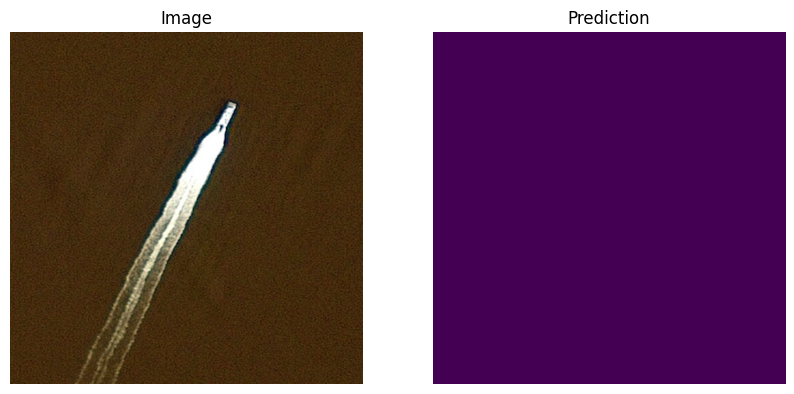

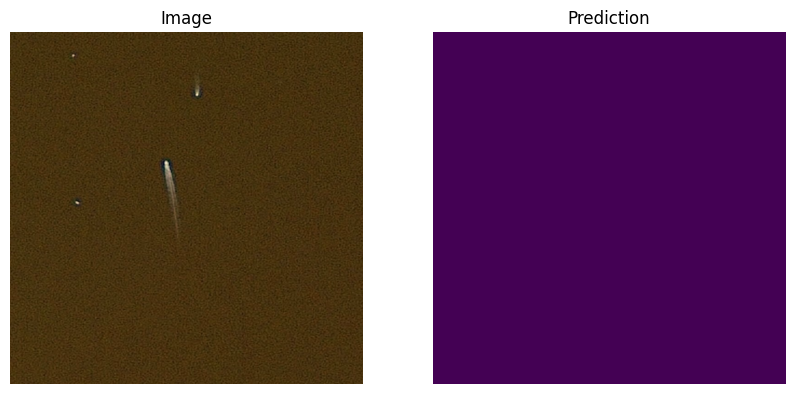

In [61]:
rows = 1
columns = 2

for i in range(len(test_imgs)):
    img, pred = gen_pred(test_imgs[i], model)
    fig = plt.figure(figsize=(10, 7))
    fig.add_subplot(rows, columns, 1)
    plt.imshow(img)
    plt.axis('off')
    plt.title("Image")
    fig.add_subplot(rows, columns, 2)
    plt.imshow(pred, interpolation = None)
    plt.axis('off')
    plt.title("Prediction")